In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader

# --- REPO SETUP ---
REPO_URL = "https://github.com/Kaankocc/autovision-cityscapes.git"
REPO_NAME = "autovision-cityscapes"

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}

# Ensure imports work regardless of folder structure
SRC_PATH = os.path.abspath(os.path.join(REPO_NAME, "src"))
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Environment initialized on: {device}")

Cloning into 'autovision-cityscapes'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 5), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 9.25 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (5/5), done.
✅ Environment initialized on: cuda


In [2]:
from utils import bake_masks

# Define Paths
RAW_DATA = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data"
PROC_DATA = "/kaggle/working/processed_masks"

if not os.path.exists(PROC_DATA):
    print("🔥 Starting Data Pipeline: Baking semantic masks...")
    bake_masks(RAW_DATA, PROC_DATA)
    print(f"✅ Preprocessing Complete. Masks stored at: {PROC_DATA}")
else:
    print("📂 Processed masks already exist. Skipping bake.")

🔥 Starting Data Pipeline: Baking semantic masks...
🔥 Baking 2975 masks for 'train' split...


100%|██████████| 2975/2975 [02:30<00:00, 19.77it/s]


🔥 Baking 500 masks for 'val' split...


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]

✅ Preprocessing Complete. Masks stored at: /kaggle/working/processed_masks


In [3]:
from model import UNet

# Load Fine-Tuned Weights
MODEL_PATH = "/kaggle/input/cityscapes-fine-tuned-pth/pytorch/default/1/cityscapes_fine_tuned.pth"

model = UNet(n_channels=3, n_classes=7).to(device)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print("💎 Phase 1 Fine-Tuned Weights Loaded.")
else:
    print("❌ ERROR: Could not find model file. Check your Kaggle Input paths.")

💎 Phase 1 Fine-Tuned Weights Loaded.


In [6]:
def run_performance_report(subset_size=100):
    print(f"📊 Analyzing {subset_size} validation samples...")
    ious = {cat: [] for cat in CATEGORIES}
    
    indices = np.random.choice(len(val_ds), subset_size, replace=False)
    
    for i in tqdm(indices):
        img, mask = val_ds[i]
        input_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred = torch.argmax(model(input_tensor).squeeze(), dim=0).cpu().numpy()
            
        for idx, cat in enumerate(CATEGORIES):
            # Convert ground truth to numpy to avoid mixed-type DeprecationWarnings in NumPy 2.0
            true_mask = (mask == idx).numpy()
            pred_mask = (pred == idx)
            
            intersection = (true_mask & pred_mask).sum()
            union = (true_mask | pred_mask).sum()
            
            if union > 0:
                ious[cat].append(intersection / union)

    # Print Report
    print("\n" + "🏆" + " PHASE 1 MIOU REPORT ".center(40, "-") + "🏆")
    print(f"{'Category':<15} | {'IoU Score':<10}")
    print("-" * 42)
    
    all_scores = []
    for cat in CATEGORIES:
        score = np.mean(ious[cat]) * 100 if ious[cat] else 0
        all_scores.append(score)
        print(f"{cat:<15} : {score:.2f}%")
    
    print("-" * 42)
    print(f"{'MEAN IoU':<15} : {np.mean(all_scores):.2f}%")
    print("=" * 42)

run_performance_report()

📊 Analyzing 100 validation samples...


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


🏆--------- PHASE 1 MIOU REPORT ----------🏆
Category        | IoU Score 
------------------------------------------
Background      : 63.31%
Road            : 90.73%
Human           : 21.03%
Vehicle         : 69.47%
Construction    : 72.60%
Object          : 19.71%
Nature          : 75.89%
------------------------------------------
MEAN IoU        : 58.96%


🕵️ Hunting for complex urban scenes...


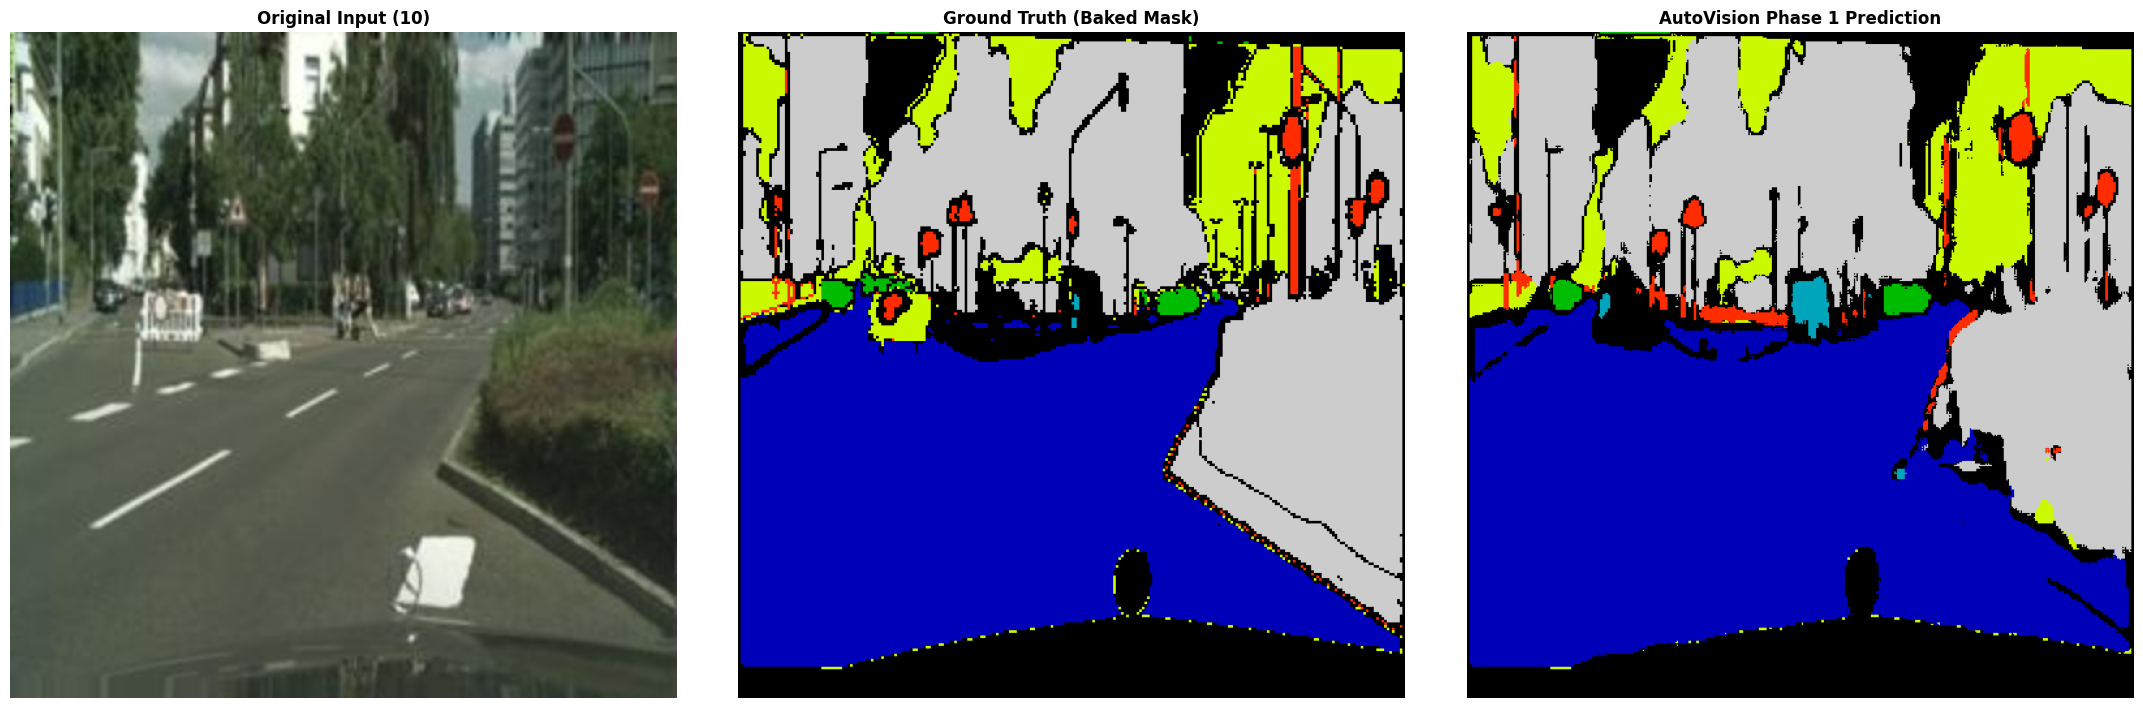

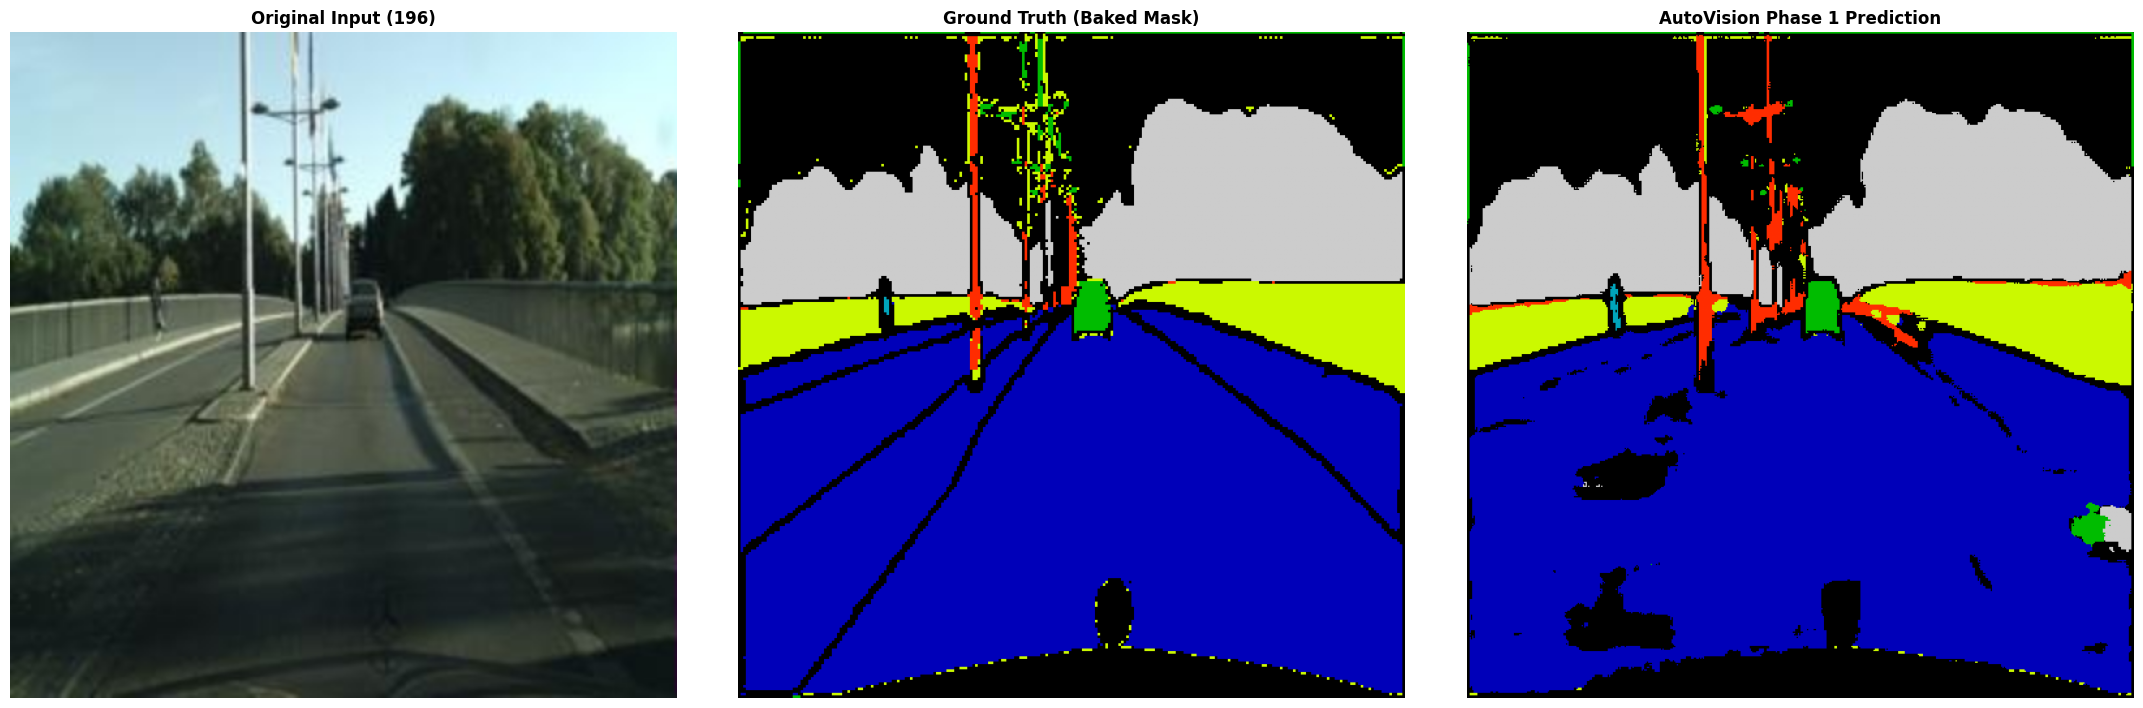

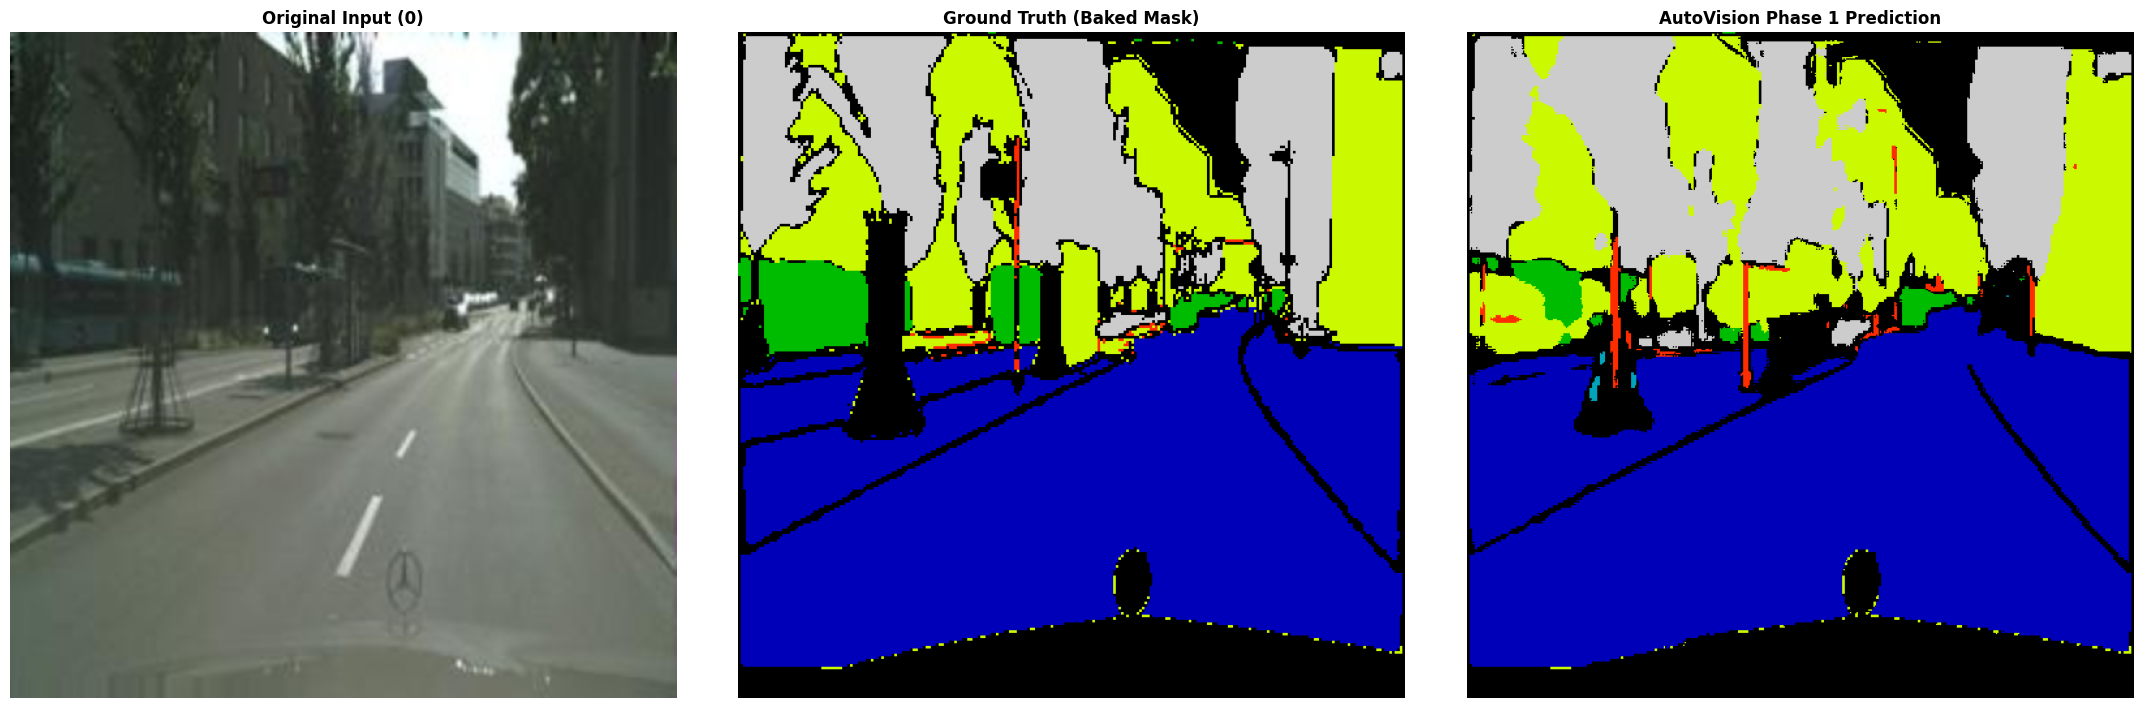

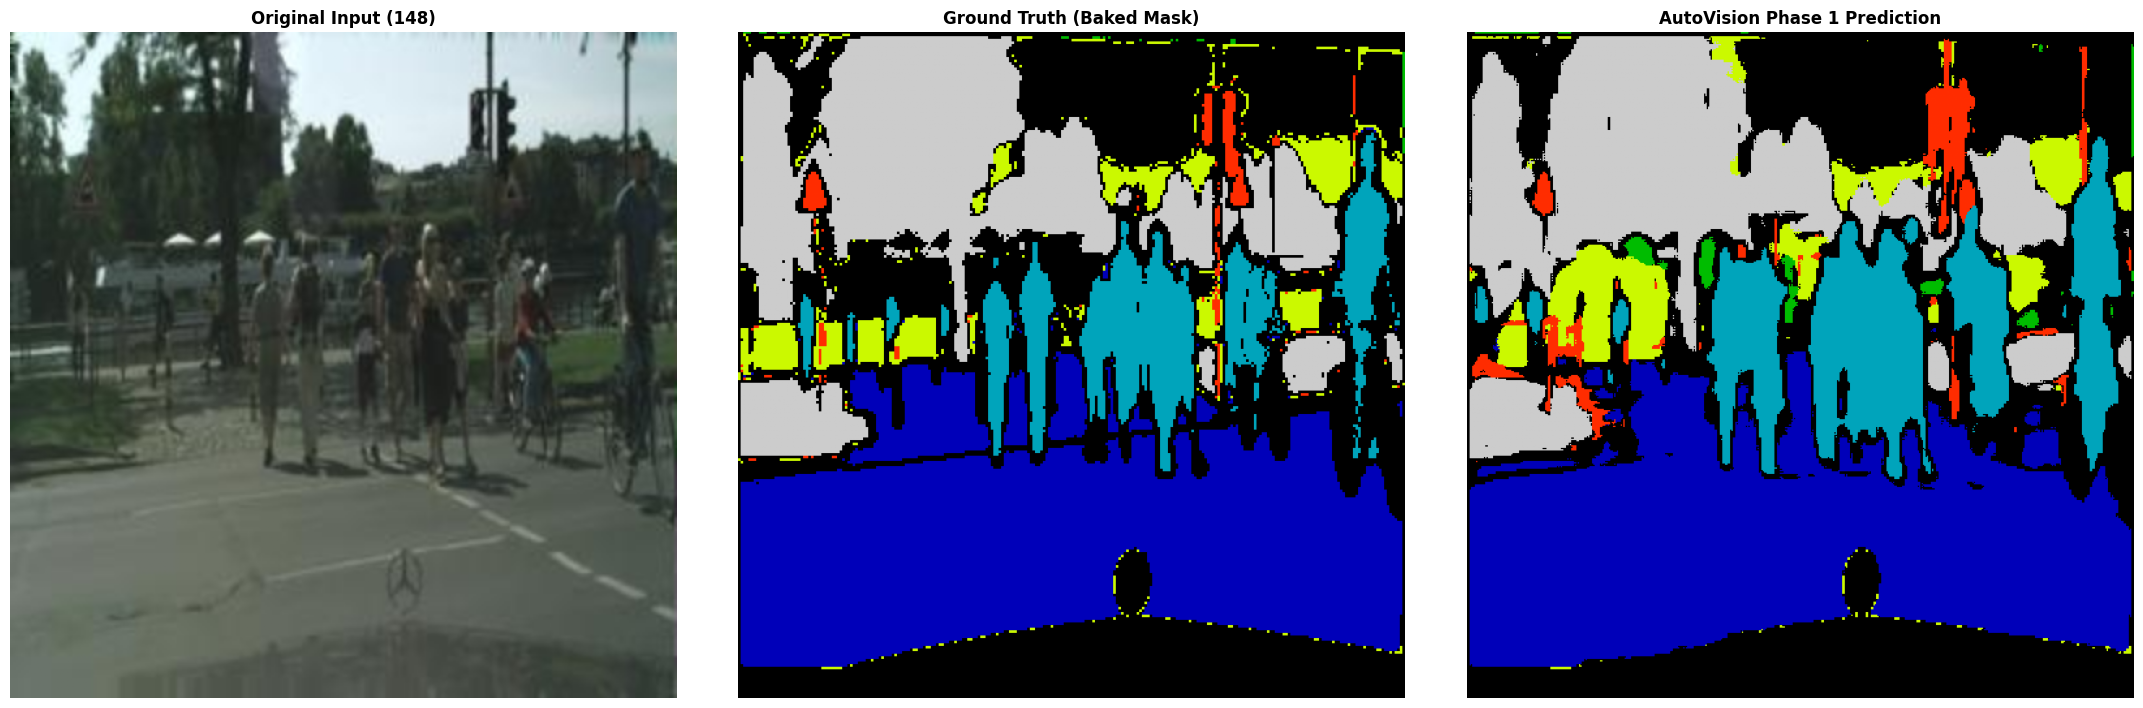

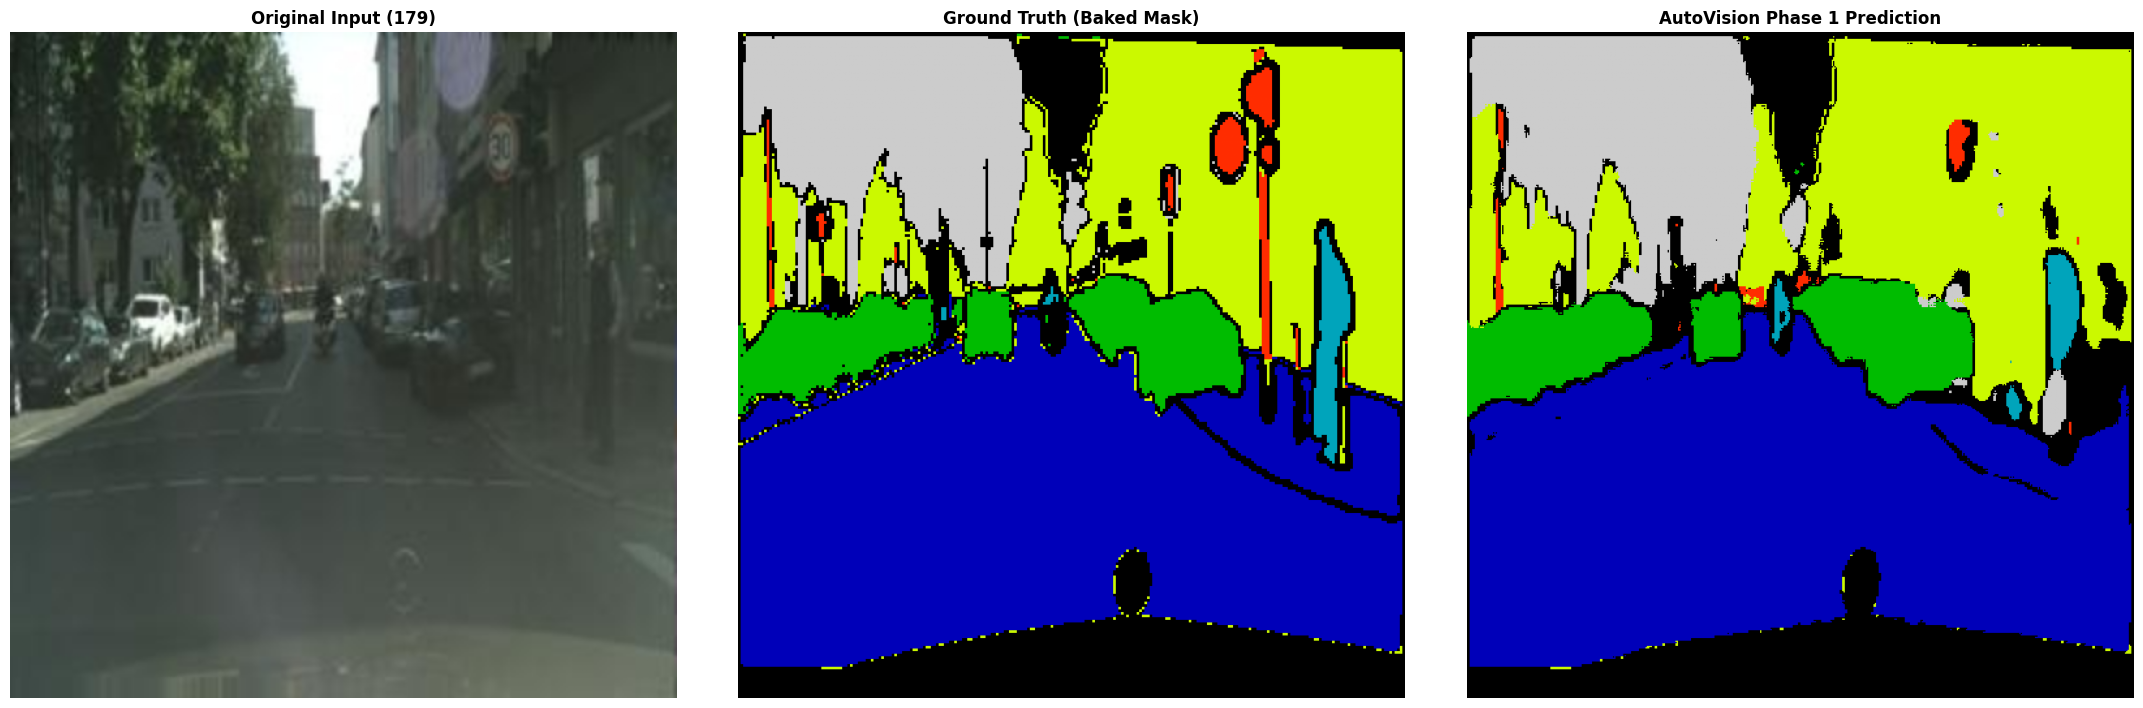

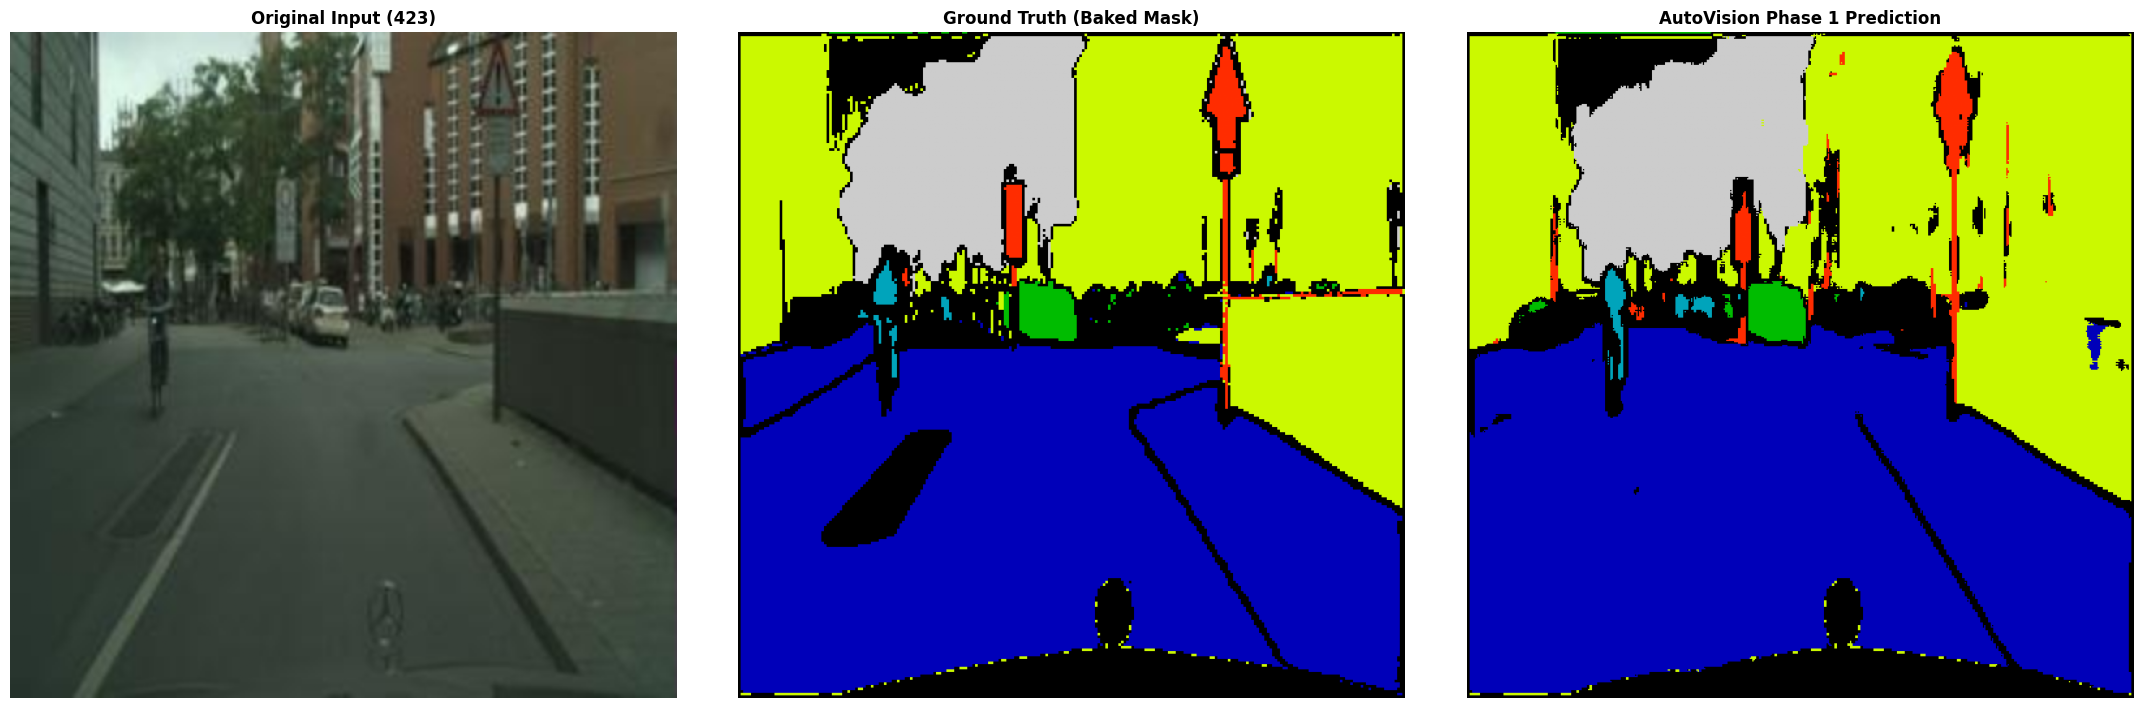

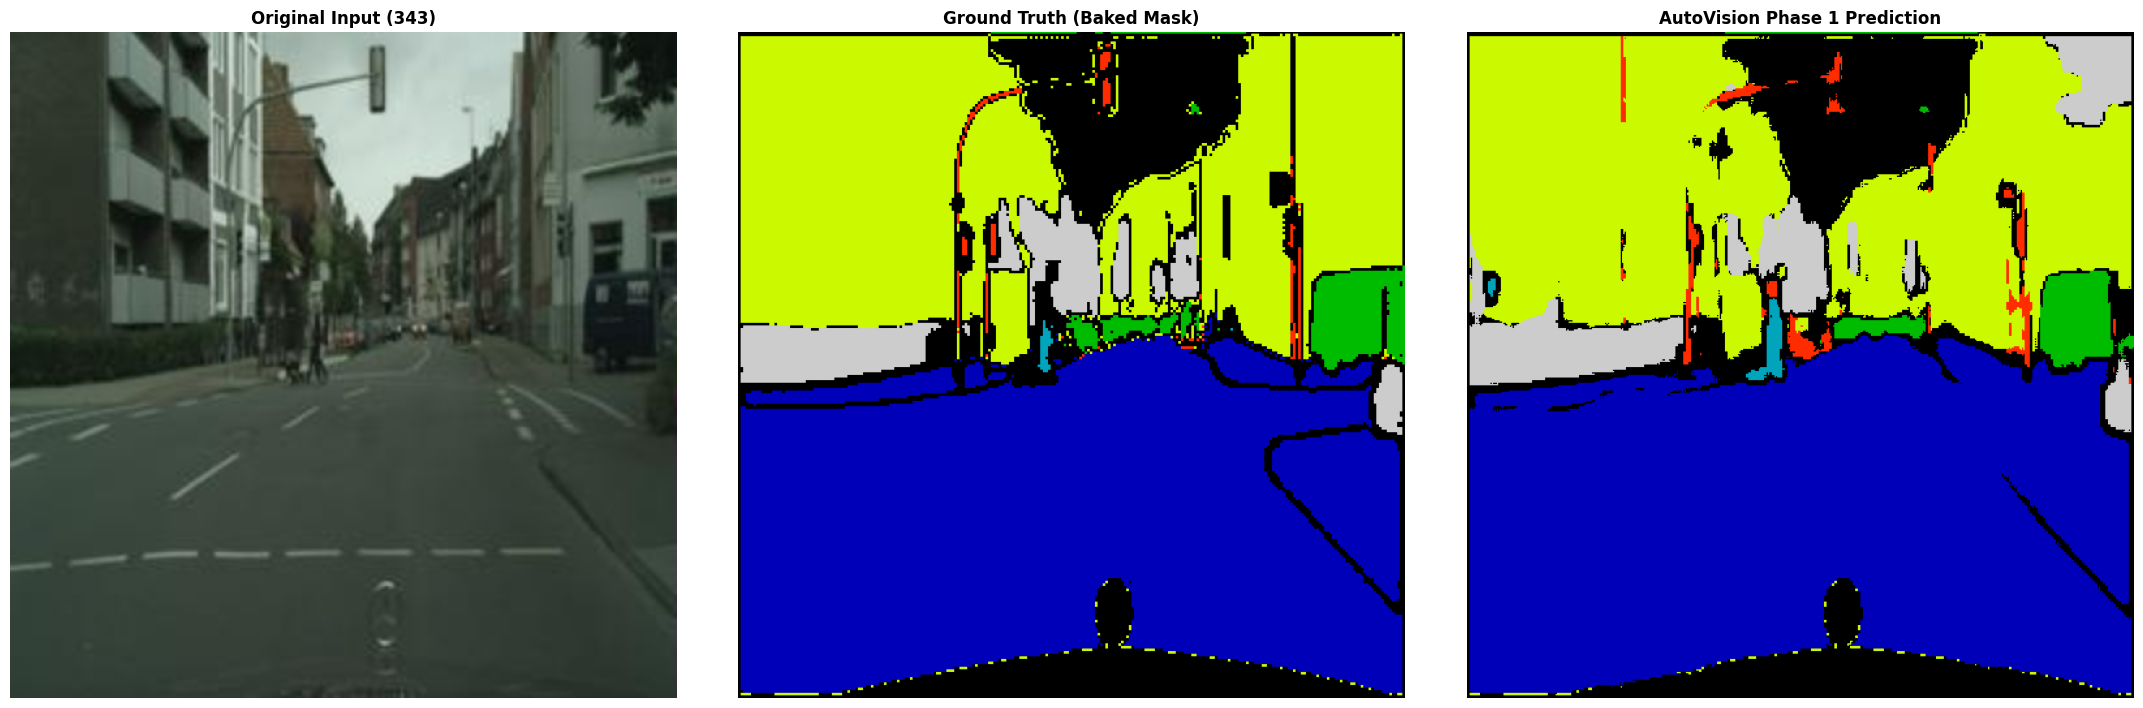

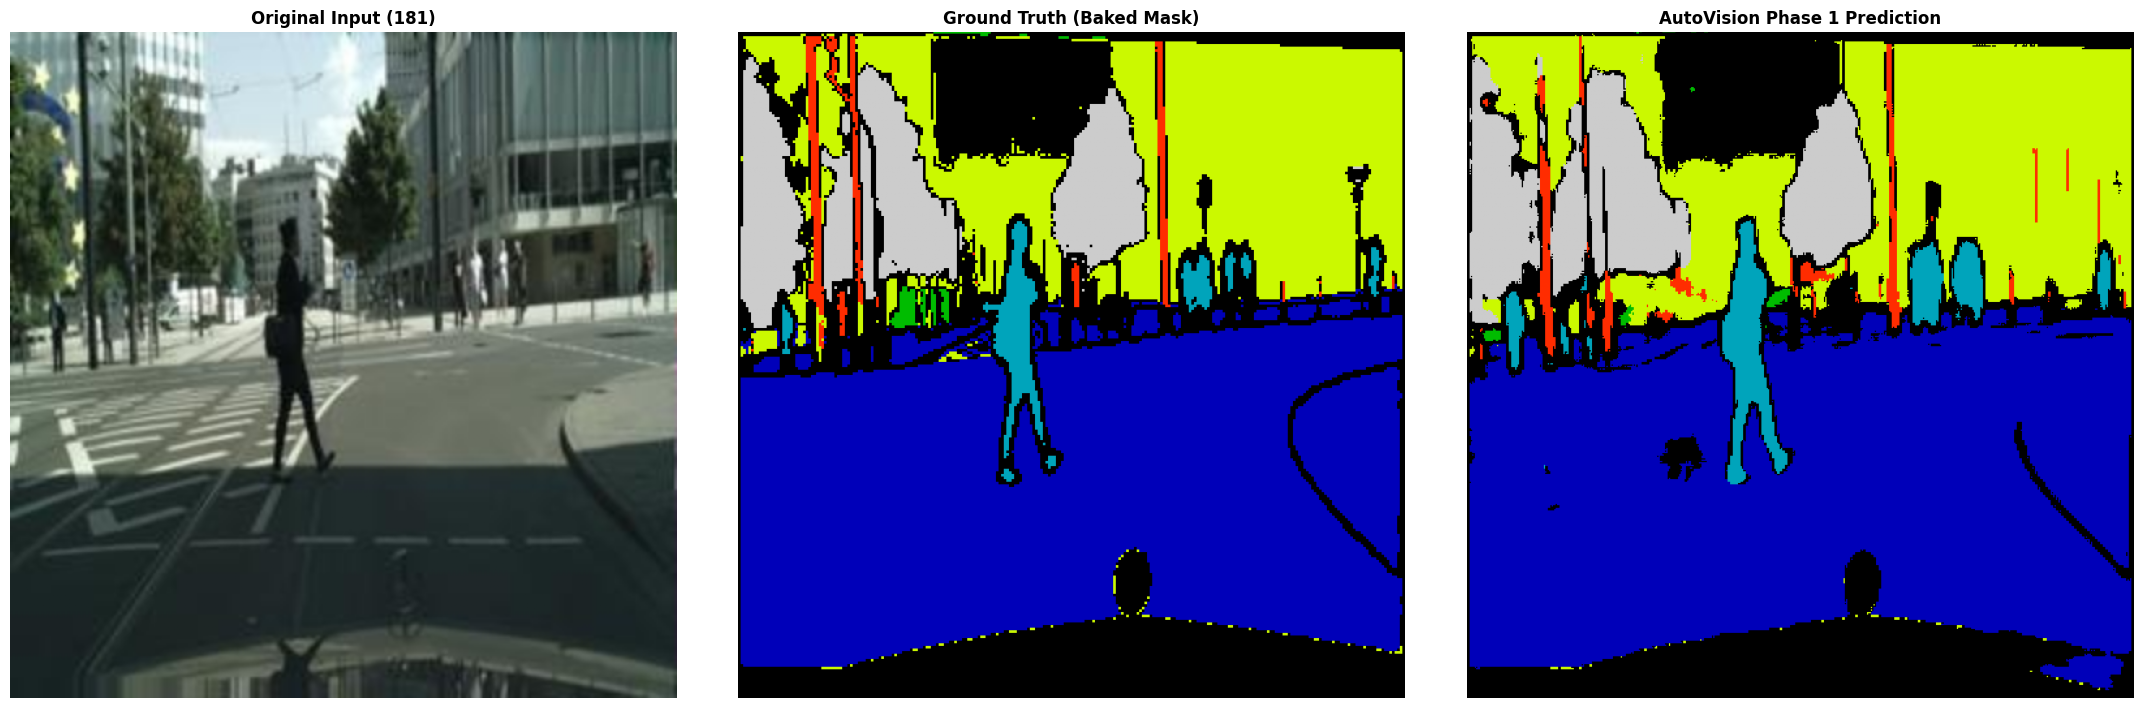

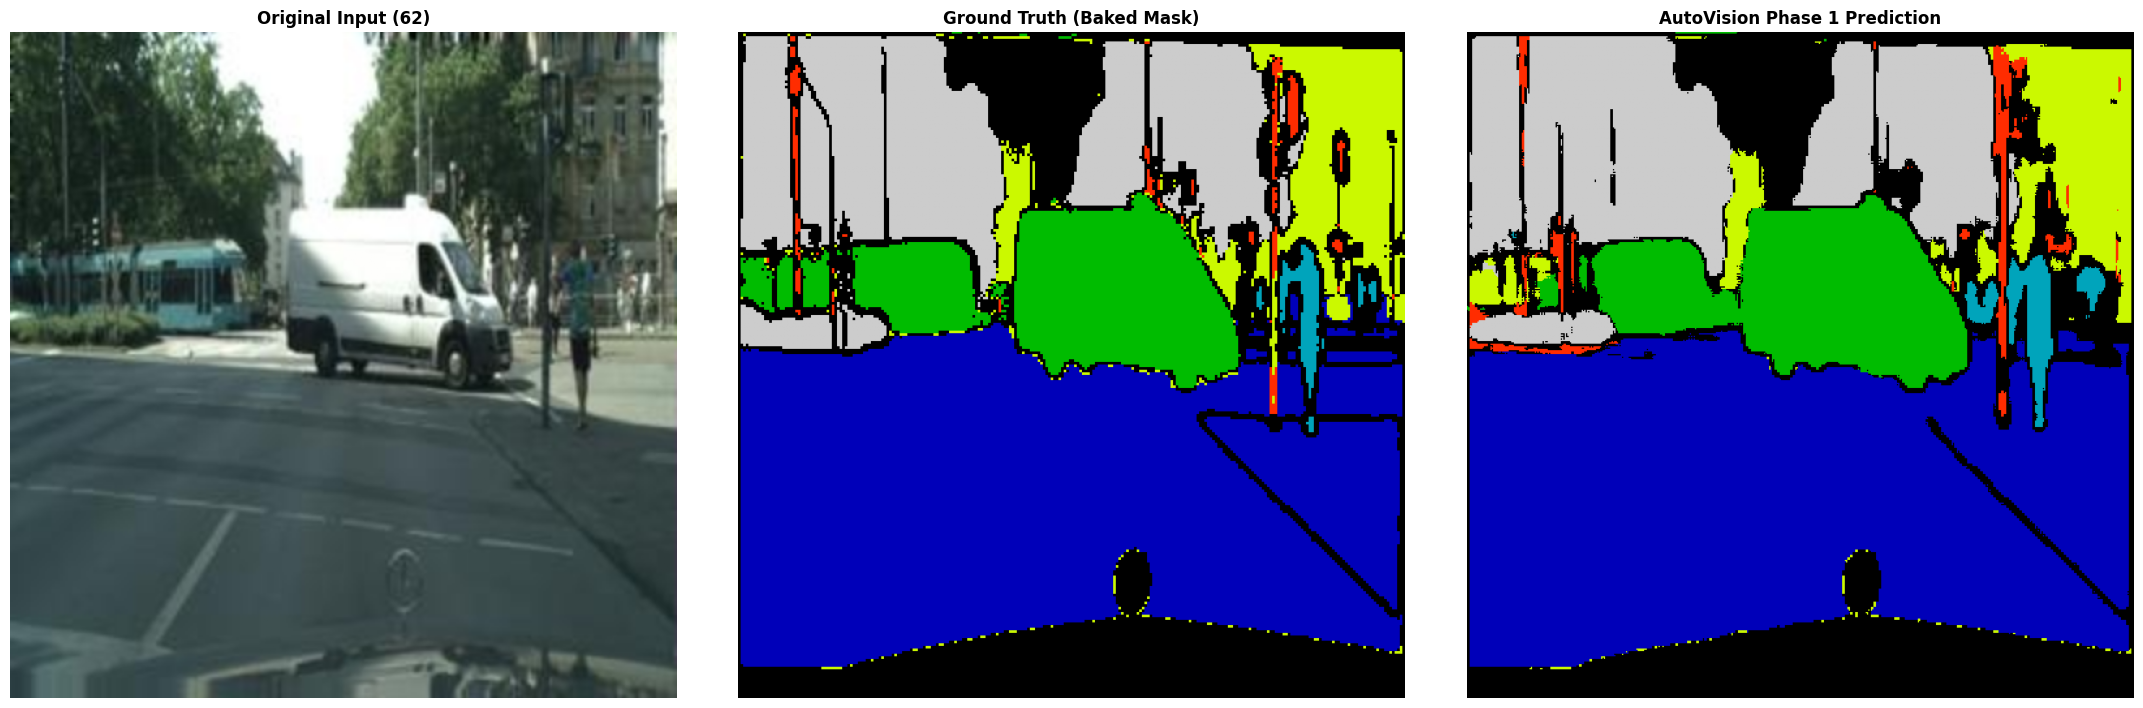

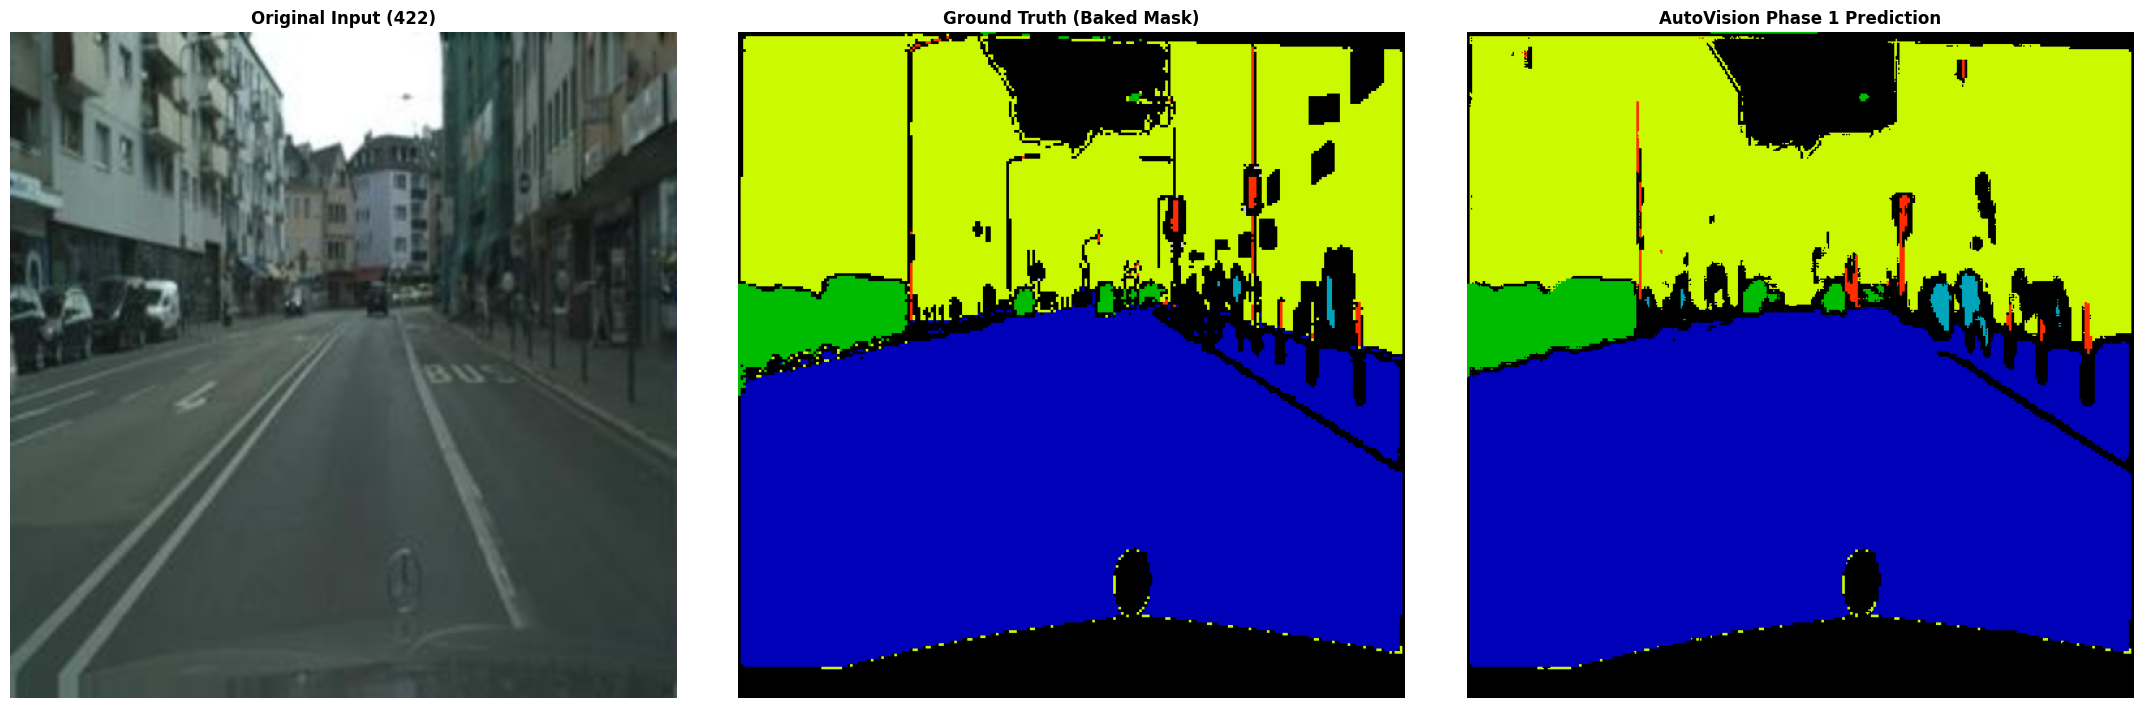

In [7]:
def visualize_results(num_samples=3):
    count = 0
    attempts = 0
    
    print("🕵️ Hunting for complex urban scenes...")
    
    while count < num_samples and attempts < 100:
        attempts += 1
        idx = np.random.randint(0, len(val_ds))
        img, mask = val_ds[idx]
        
        # Focus on scenes with Humans or specific Objects
        if (mask == 2).sum() > 300 or (mask == 5).sum() > 300:
            count += 1
            with torch.no_grad():
                input_t = img.unsqueeze(0).to(device)
                pred = torch.argmax(model(input_t).squeeze(), dim=0).cpu().numpy()
            
            # Rendering
            fig, ax = plt.subplots(1, 3, figsize=(22, 7))
            
            ax[0].imshow(img.permute(1, 2, 0).numpy())
            ax[0].set_title(f"Original Input ({idx})", fontweight='bold')
            ax[0].axis('off')
            
            ax[1].imshow(mask, cmap='nipy_spectral', vmin=0, vmax=6)
            ax[1].set_title("Ground Truth (Baked Mask)", fontweight='bold')
            ax[1].axis('off')
            
            ax[2].imshow(pred, cmap='nipy_spectral', vmin=0, vmax=6)
            ax[2].set_title("AutoVision Phase 1 Prediction", fontweight='bold')
            ax[2].axis('off')
            
            plt.tight_layout()
            plt.show()

visualize_results(num_samples=10)